In [108]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [4]:
df = pd.read_csv('heart_attack_dataset.csv')

In [110]:
# print(df.shape)
# print(df.head())
# categorization of columns for reference
BinaryColumns = ['Smoker', 'Diabetes', 'Hypertension', 'FamilyHistory', 
                'AlcoholConsumption', 'Medication', 'ExerciseInducedAngina', 
                 'PreviousHeartAttack', 'StrokeHistory']
    
ContinuousColumns = ['Age', 'Cholesterol', 'BloodPressure', 'HeartRate', 'BMI', 'PhysicalActivity', 
                     'Income', 'MaxHeartRate', 'ST_Depression', 'NumberOfMajorVessels']
    
CategoricalColumns = ['Gender', 'Diet', 'StressLevel', 'Ethnicity', 
                      'EducationLevel', 'ChestPainType', 'ECGResults', 
                      'Slope', 'Thalassemia', 'Residence', 'EmploymentStatus', 
                      'MaritalStatus']

In [146]:
# extract features
binary_features = df[['Smoker', 'Diabetes', 'Hypertension']].values
continuous_features = df[['Age', 'Cholesterol', 'BloodPressure']].values
categorical_features = df[['Ethnicity']]

# one-hot encode categorical features 
categorical_features = pd.get_dummies(categorical_features, drop_first=True).values

# normalize continuos features
scaler = StandardScaler()
continuous_features = scaler.fit_transform(continuous_features)

# combine all features
X = np.concatenate([binary_features, continuous_features, categorical_features], axis=1)

In [147]:

# extract target
y = df['Outcome'].values
# convert 'heartk attack' and 'not heart attack' to binary output
y = (y == 'Heart Attack').astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

# standardize inputs
scaler = StandardScaler()
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32).view(-1, 1)

In [148]:
# note: after one hot encoding, each category from each categorical feature becomes its own feature
# therefore, for example, 9 chosen columns could actually mean 14 columns
# remember that when creating the first NN layer!
print(X.shape)

(372974, 10)


In [145]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(13, 32) # input layer.  note: first input num must match number of input features
        self.fc2 = nn.Linear(32, 16) # hidden layer 1
        self.fc3 = nn.Linear(16, 5) # hidden layer 2
        self.fc_out = nn.Linear(5, 1)  # hidden layer 2 to output layer
        self.dropout = nn.Dropout(p=0.0)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))   # ReLu on hidden layer 1
        x = torch.relu(self.fc2(x))   # ReLu on hidden layer 2
        x = torch.relu(self.fc3(x))   # ReLu on hidden layer 3
        x = self.sigmoid(self.fc_out(x)) # sigmoid activiation on output
        return x

In [136]:
# hyper-parameters
learn_rate = 0.0001
epochs = 100

In [137]:
# the model defined above
model = NN()

# loss function 
criterion = nn.BCELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = learn_rate)

In [138]:
# training and validation
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 100
for epoch in range(epochs):
    # training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # calculate training accuracy
    predictions = (outputs > 0.5).float()
    correct = (predictions == y_train).float().sum()
    accuracy = correct / y_train.shape[0]

    # training metrics
    train_losses.append(loss.item())
    train_accuracies.append(accuracy.item())

    # validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)

        # calculate validation accuracy
        val_predictions = (val_outputs > 0.5).float()
        val_correct = (val_predictions == y_test).float().sum()
        val_accuracy = val_correct / y_test.shape[0]

        # store validation metrics
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())

    # print metrics every few epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {loss.item():.4f}, Training Accuracy: {accuracy.item():.4f}, '
              f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy.item():.4f}')

Epoch [10/100], Training Loss: 0.6932, Training Accuracy: 0.4999, Validation Loss: 0.6932, Validation Accuracy: 0.5018
Epoch [20/100], Training Loss: 0.6932, Training Accuracy: 0.4998, Validation Loss: 0.6932, Validation Accuracy: 0.5012
Epoch [30/100], Training Loss: 0.6932, Training Accuracy: 0.4997, Validation Loss: 0.6932, Validation Accuracy: 0.5014
Epoch [40/100], Training Loss: 0.6932, Training Accuracy: 0.5000, Validation Loss: 0.6932, Validation Accuracy: 0.4998
Epoch [50/100], Training Loss: 0.6932, Training Accuracy: 0.5004, Validation Loss: 0.6932, Validation Accuracy: 0.4999
Epoch [60/100], Training Loss: 0.6932, Training Accuracy: 0.5010, Validation Loss: 0.6932, Validation Accuracy: 0.4990
Epoch [70/100], Training Loss: 0.6932, Training Accuracy: 0.5011, Validation Loss: 0.6932, Validation Accuracy: 0.4996
Epoch [80/100], Training Loss: 0.6932, Training Accuracy: 0.5014, Validation Loss: 0.6932, Validation Accuracy: 0.4997
Epoch [90/100], Training Loss: 0.6931, Training 

Maximum Training Accuracy: 0.5020
Maximum Validation Accuracy: 0.5036


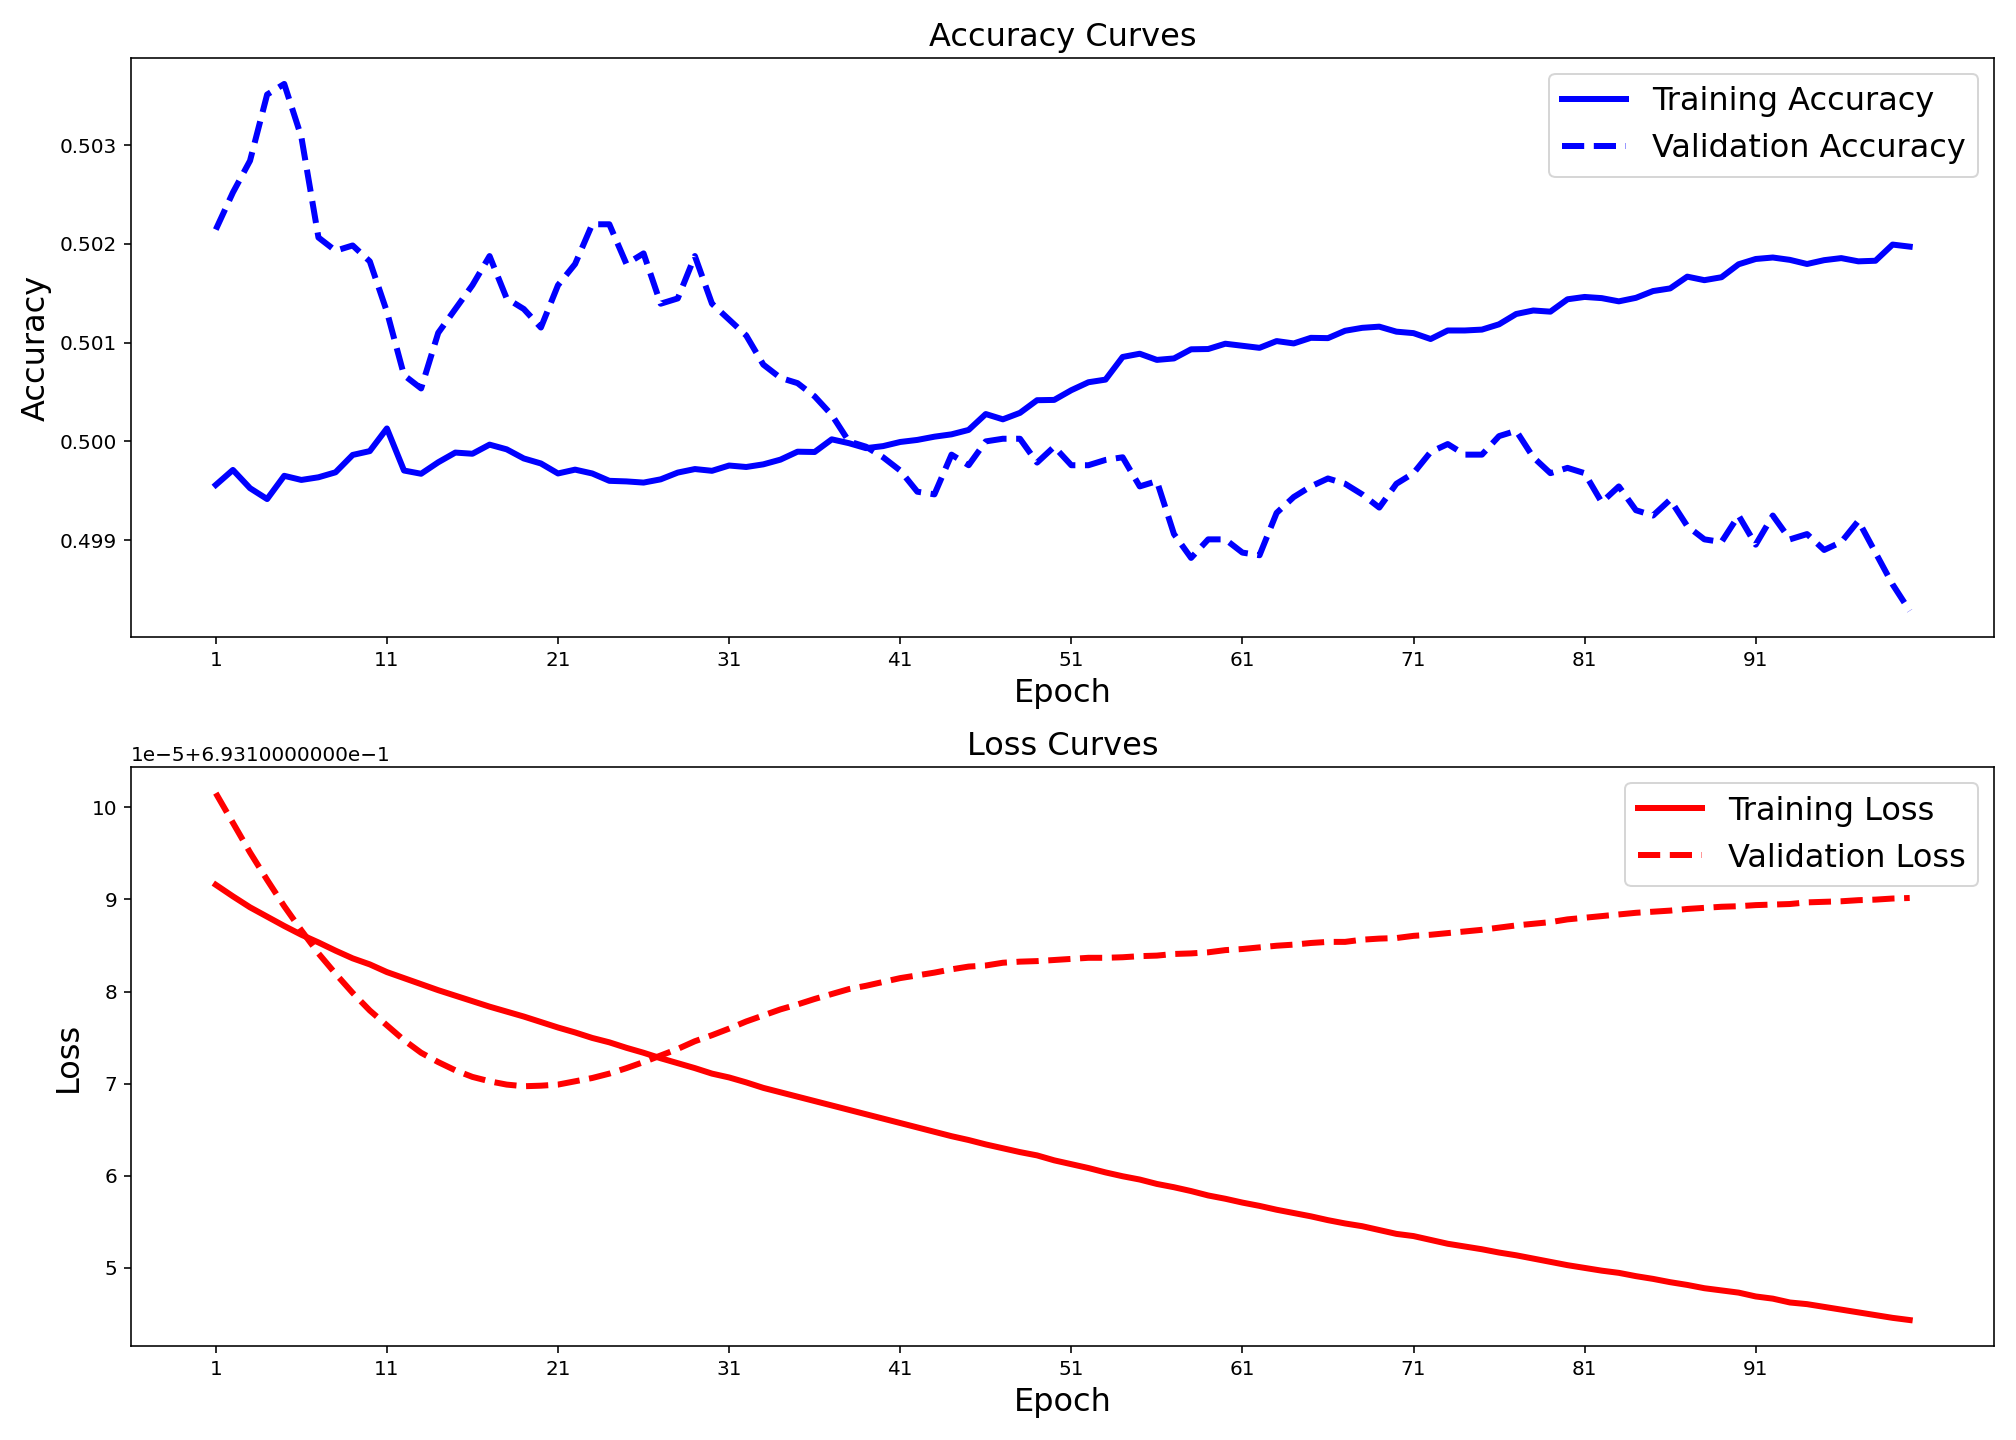

In [139]:
# max accuracies
print(f"Maximum Training Accuracy: {max(train_accuracies):.4f}")
print(f"Maximum Validation Accuracy: {max(val_accuracies):.4f}")

# accuracy curves
plt.figure(figsize=[14, 10])
plt.subplot(2, 1, 1) # note: divides output into 2 rows, 1 col, and this figure has position 1
plt.plot(train_accuracies, 'b', linewidth=3.0, label='Training Accuracy')
plt.plot(val_accuracies, 'b--', linewidth=3.0, label='Validation Accuracy')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(np.arange(0, epochs, 10), np.arange(1, epochs + 1, 10))
plt.title('Accuracy Curves', fontsize=16)

# loss curves
plt.subplot(2, 1, 2)
plt.plot(train_losses, 'r', linewidth=3.0, label='Training Loss')
plt.plot(val_losses, 'r--', linewidth=3.0, label='Validation Loss')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(np.arange(0, epochs, 10), np.arange(1, epochs + 1, 10))
plt.title('Loss Curves', fontsize=16)

plt.tight_layout()
plt.show()